In [45]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24


In [46]:
inputImageFile = ('/disk1/rpn/data/BM_GRAZ/source/BM_GRAZ_HE_0008_01.png')  

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

#plt.imshow(imInput)
#_ = plt.title('Input Image', fontsize=16)

In [47]:
refImageFile = ('/disk1/rpn/data/BM_GRAZ/source/BM_GRAZ_HE_0001_01.png')
imReference = skimage.io.imread(refImageFile)[:, :, :3]

# get mean and stddev of reference image in lab space
meanRef, stdRef = htk.preprocessing.color_conversion.lab_mean_std(imReference)

# perform reinhard color normalization
imNmzd = htk.preprocessing.color_normalization.reinhard(imInput, meanRef, stdRef)

# Display results
#plt.figure()
#plt.imshow(imReference)
#_ = plt.title('Reference Image', fontsize=titlesize)

#plt.figure()
#plt.imshow(imNmzd)
#_ = plt.title('Normalized Input Image', fontsize=titlesize)

In [48]:
intense = htk.preprocessing.color_normalization.background_intensity(imNmzd)

ValueError: Exactly one of sample_fraction and sample_approximate_total must have a value.

In [49]:
imNmzd = imInput
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.64, 0.72, 0.27],
    'eosin':       [0.09, 0.95, 0.28],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains


# create initial stain matrix
W_init = np.array([stainColorMap[stain_1],
                   stainColorMap[stain_2]]).T

# perform sparse color deconvolution
sparsity_factor = 0.5

imDeconvolved, W_est = htk.preprocessing.color_deconvolution.sparse_color_deconvolution(
    imInput, W_init, sparsity_factor)

print 'Estimated stain colors (in rows): '
print W_est.T


# Display results

#plt.figure()
#plt.imshow(imDeconvolved[:, :, 0])
#plt.title(stain_1, fontsize=titlesize)

#plt.figure()
#plt.imshow(imDeconvolved[:, :, 1])
#_ = plt.title(stain_2, fontsize=titlesize)


Estimated stain colors (in rows): 
[[ 0.63665234  0.66028317  0.3983716 ]
 [ 0.22570451  0.89136213  0.39310434]]


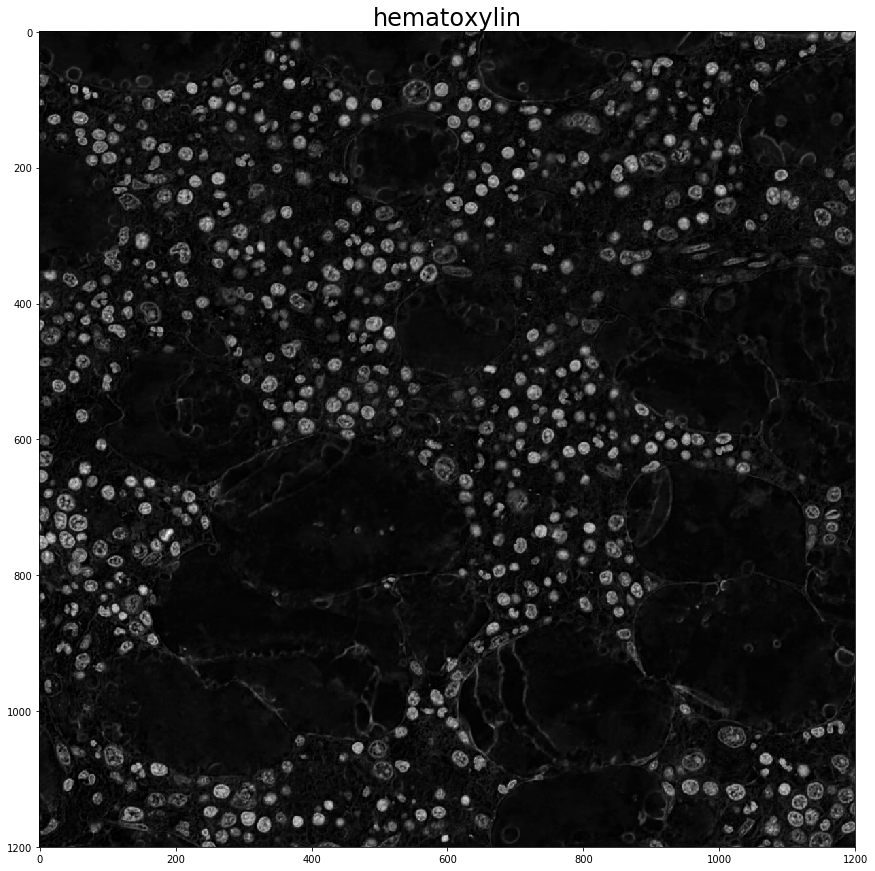

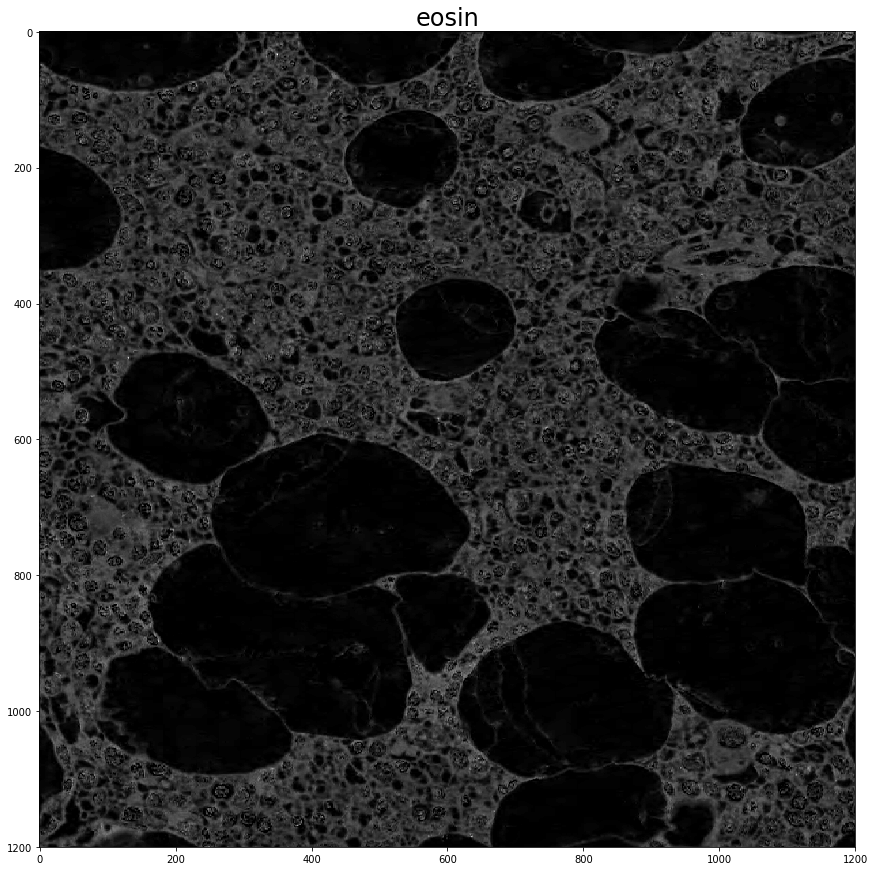

In [50]:
plt.figure()
plt.imshow(imDeconvolved[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.figure()
plt.imshow(imDeconvolved[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)


In [51]:
imNucleiStain = 255 - imDeconvolved[:, :, 0]

#imNucleiStain =imDeconvolved[:, :, 1]
foreground_threshold = 220

imFgndMask = sp.ndimage.morphology.binary_fill_holes(
    imNucleiStain < foreground_threshold)

#plt.figure()
#plt.imshow(imFgndMask)


In [53]:
# run adaptive multi-scale LoG filter
min_radius = 3
max_radius = 15
size = 32

imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,
                               sigma_min=min_radius * np.sqrt(2),
                               sigma_max=max_radius * np.sqrt(2))

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 5

imNucleiSegMask, Seeds, Max = htk.segmentation.nuclear.max_clustering(
    imLog[0], imFgndMask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

imNucleiSegMask = htk.segmentation.label.area_open(
    imNucleiSegMask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleiSegMask)

print 'Number of nuclei = ', len(objProps)

Number of nuclei =  767


In [56]:
imNucleiSegMask.shape

(1200, 1200)

In [52]:
# run adaptive multi-scale LoG filter
min_radius = 3
max_radius = 15
size = 32

imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,
                               sigma_min=min_radius * np.sqrt(2),
                               sigma_max=max_radius * np.sqrt(2))

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 5

imNucleiSegMask, Seeds, Max = htk.segmentation.nuclear.max_clustering(
    imLog[0], imFgndMask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

imNucleiSegMask = htk.segmentation.label.area_open(
    imNucleiSegMask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleiSegMask)

print 'Number of nuclei = ', len(objProps)
plt.rcParams['figure.figsize'] = 1, 1
image_dict = {}

for i,n in enumerate(objProps):
    w, h = int(n.centroid[0]),int(n.centroid[1])
    w_convex, h_convex = int(n.convex_image.shape[0]), int(n.convex_image.shape[1])
    if min(w-w_convex/2,h-w_convex/2)<=0 or max(w+h_convex/2,h+h_convex/2)>=1200:
        continue
    if min(output.shape)==0:
        continue
    #if min(size/2-w_convex/2,  size/2-h_convex/2)<=0 or max(size/2-w_convex/2+w_convex, size/2-h_convex/2+h_convex) >=size:
        #continue
    output = imInput[w-w_convex/2:w+w_convex/2,h-h_convex/2:h+h_convex/2,:]
    output = sp.misc.imresize(output, (32,32))
    #plt.imshow(output)
    #plt.show()
    image_dict[i] = output

image = np.array(image_dict.values())
print ('done')

Number of nuclei =  767


NameError: name 'output' is not defined

In [44]:
imNucleiSegMask

NameError: name 'imNucleiSegMask' is not defined

In [ ]:


plt.rcParams['figure.figsize'] = 1,1
size = 32
output = np.ones((size,size,3),dtype=np.uint8)*255
output_convex = np.zeros((size,size,1),dtype=bool)
image_dict = {}

for i,n in enumerate(objProps):
    w, h = int(n.centroid[0]),int(n.centroid[1])
    w_convex, h_convex = int(n.convex_image.shape[0]), int(n.convex_image.shape[1])
    if min(w-size/2,h-size/2)<=0 or max(w+size/2,h+size/2)>=1200:
        continue
    if min(size/2-w_convex/2,  size/2-h_convex/2)<=0 or max(size/2-w_convex/2+w_convex, size/2-h_convex/2+h_convex) >=size:
        continue
    output[: ,: ,:] = imInput[w-size/2:w+size/2,h-size/2:h+size/2,:]
    output_convex[size/2-w_convex/2:size/2-w_convex/2+w_convex, size/2-h_convex/2:size/2-h_convex/2+h_convex, 0]  \
            = n.convex_image#.transpose(1,0)
    result = np.tile(output_convex, (1, 1, 3))*output
    image_dict[i] = result    
    #result = output
    #plt.imshow(result)
    #plt.show()
    
    output = np.ones((size,size,3),dtype=np.uint8)*255
    output_convex = np.zeros((size,size,1),dtype=bool)

image = np.array(image_dict.values())

In [ ]:
image_dict.values()

In [ ]:
np.save('/disk1/cell_segment_save/{0}_image_dict.npy'.format(1),image_dict)

In [ ]:
image.shape

In [ ]:
image_dict = {}
image_dict[0] = np.ones((3,3))
image_dict[1] = np.zeros((3,3))
np.array(image_dict.values()).shape

In [ ]:
16-w_convex/2

In [ ]:
n.image.shape

In [ ]:
print(n.centroid[1],n.centroid[0])

In [ ]:
n.convex_image.shape

In [ ]:
width = n.bbox[3] - n.bbox[1] + 1
height = n.bbox[2] - n.bbox[0] + 1
print(width,height)

In [ ]:
a = np.zeros((32,32,1),dtype=bool)
b = np.ones((32,32,3),dtype=np.uint8)
np.tile(a, (1, 1, 3))*b


In [ ]:
a = np.zeros((32,32),dtype=bool)
a.expand_dims()

In [ ]:
from faster_rcnn.faster_rcnn import nms_detections
from numpy import random
randArray = random.rand(len(objProps))
Bbox= np.zeros((len(objProps),4),dtype=np.float32)
keep_scores = np.zeros((len(objProps)),dtype=np.float32)
#keep_scores=randArray#用random的
for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }
    Bbox[i]=[c[0] - 0.5 * width, c[1] - 0.5 * height,c[0] + 0.5 * width,c[1] + 0.5 * height]

    

In [ ]:
pred_boxes, scores = nms_detections(Bbox, keep_scores, nms_thresh = 0.2, inds=None)

In [ ]:
####有center

plt.figure()
plt.imshow( imInput )
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for j in range(0,len(pred_boxes)):
    for i in range(0,len(Bbox)):
        boxbool=pred_boxes[j]==Bbox[i]
        if boxbool[0]& boxbool[1]& boxbool[2]& boxbool[3]:
            c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
            width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
            height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1
            cur_bbox = {
            "type":        "rectangle",
            "center":      c,
            "width":       width,
            "height":      height,
            }
            plt.plot(c[0], c[1], 'g+')
            mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,width, height, fill=False, ec='g', linewidth=2)
            plt.gca().add_patch(mrect)
        

In [ ]:
from segmentation_process import segmentation

inputImageFile = ('/disk1/rpn/data/BM_GRAZ/source/BM_GRAZ_HE_0001_02.png')  
segmentation(inputImageFile)

In [ ]:
from segmentation_process import segmentation
import os 
from multiprocessing import Pool as ThreadPool

pool = ThreadPool(8) 
root_dir = '/disk1/rpn/data/BM_GRAZ/source/'
imageList = os.listdir(root_dir)
imageList = [root_dir+n for n in imageList]
pool.map(segmentation, imageList)

In [ ]:
from segmentation_process import segmentation
import os 
from multiprocessing import Pool as ThreadPool
#from multiprocessing.dummy import Pool as ThreadPool

pool = ThreadPool(12) 
root_dir = '/disk1/rpn/data/BM_GRAZ/source/'
imageList = os.listdir(root_dir)
imageList = [root_dir+n for n in imageList]
pool.map(segmentation, imageList)

In [ ]:
segmentation(imageList[1])

In [4]:
import numpy as np
cell = np.load('/disk1/cell_work/data/data.npy')

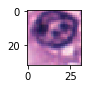

In [24]:
plt.rcParams['figure.figsize'] = 1, 1

plt.imshow(cell[0][:,:,::-1].astype(np.uint8))
plt.show()



In [140]:
imDeconvolved[:, :, 0]

(32, 32)

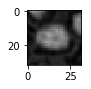

In [142]:
imDeconvolved, W_est = htk.preprocessing.color_deconvolution.sparse_color_deconvolution(
    test, W_init, sparsity_factor)
X = np.tile(imDeconvolved[:, :, 0].reshape(32,32,1), (1, 1, 3))
plt.imshow(X)
plt.show()

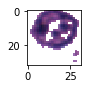

In [131]:
test2 = np.ones((32,32,3),dtype=np.uint8) *255
mean0 = test.mean(axis=0).mean(axis=0)[0]
for i in range(0,32):
    for n in range(0,32):
        if test[i,n,0]<mean0:
            test2[i,n,:] = test[i,n,:]

plt.imshow(test2)
plt.show()

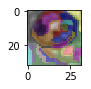

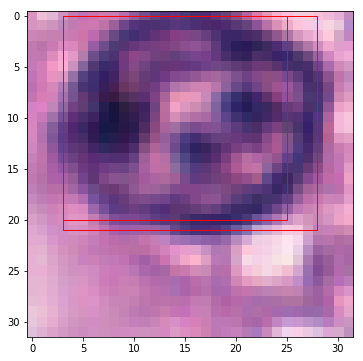

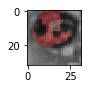

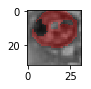

In [163]:
import skimage
import selectivesearch

for n in range(0,1):
    test = cell[n][:,:,::-1].astype(np.uint8)
    #imDeconvolved, W_est = htk.preprocessing.color_deconvolution.sparse_color_deconvolution(
    #test, W_init, sparsity_factor)
    #test = np.tile(imDeconvolved[:, :, 0].reshape(32,32,1), (1, 1, 3))
    img_lbl, regions = selectivesearch.selective_search(test, scale=1.0, sigma=0.8, min_size=10)
    image_label = img_lbl[:,:,3].reshape(32,32)
    plt.imshow(skimage.color.label2rgb(image_label, test, bg_label=0))
    plt.show()
    candidates = set()
    label_list = []

    for r in regions:
    # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
    # excluding regions smaller than 2000 pixels
        if r['size'] < 200:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w*h > 800:
            continue
       # if w / h > 1.2 or h / w > 1.2:
            #continue
        label_list.append(r['labels'])
        candidates.add(r['rect'])

        # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(test)
    for x, y, w, h in candidates:
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
    plt.show()


    candidates_list = [np.array([image_label == n for n in m]).sum(axis=0) for m in label_list]
    for i in candidates_list:
        plt.imshow(skimage.color.label2rgb(i, test, bg_label=0))
        plt.show()

{(3, 0, 22, 20), (3, 0, 25, 21)}

(3, 0)
(25, 21)
(4, 6)


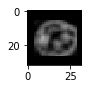

In [181]:
output = np.ones((size,size,3),dtype=np.uint8)*0
output_convex = np.zeros((size,size,1),dtype=bool)
image_dict = {}
size = 32

imDeconvolved, W_est = htk.preprocessing.color_deconvolution.sparse_color_deconvolution(
    test, W_init, sparsity_factor)
test = np.tile(imDeconvolved[:, :, 0].reshape(32,32,1), (1, 1, 3))

for x, y, w, h in candidates:
    continue
print(x,y)
print(w,h)
x_center = x+w/2
y_center = y+h/2
print(16-w/2,16-h/2)
output[16-h/2:16-h/2+h,16-w/2:16-w/2+w,:] = test[y:y+h,x:x+w,:] 

plt.imshow(output)
plt.show()